# Locality-Sensitive Hashing (LSH) for ANN

This notebook evaluates approximate nearest neighbor search using Locality-Sensitive Hashing (LSH) with random hyperplanes (E2LSH family).

## Method
LSH uses randomized hash functions designed such that similar points collide with high probability:
- Build L hash tables, each with different random hash functions
- For each hash table, use k random hyperplanes to create hash buckets
- At query time, hash the query point and search only in matching buckets

## Metrics
- **Recall@10**: Proportion of true nearest neighbors retrieved
- **Query time**: Time per query in milliseconds
- **Build time**: Time to construct hash tables
- **Memory**: Total index size in MB

## LSH Parameters to Sweep
- **L (num_tables)**: Number of hash tables ∈ {5, 10, 20, 40}
- **k (hash_bits)**: Number of hash bits per table ∈ {8, 12, 16, 20}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.random_projection import GaussianRandomProjection

from collections import defaultdict
import time
import sys
import json
import os
from typing import List, Tuple

# Import our custom modules
sys.path.append('..')  # If running from notebooks/ subdirectory
from evaluator import ANNEvaluator
from datasets import DatasetLoader, print_dataset_info

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

print("Imports successful!")

Imports successful!


## 1. Configuration

In [2]:
# Configuration
K = 1  # Number of nearest neighbors
DATA_DIR = "data"  # Adjust if needed
# JL Projection parameters
JL_EPSILON = 0.1  # Distance preservation parameter (smaller = more dimensions needed)
JL_DENSITY = 'auto'  # Sparsity of random matrix ('auto' recommended)

# Which datasets to evaluate
DATASETS = [
    'sift',
    # 'gist',
    # 'deep1b'
]

# LSH parameter grid
NUM_TABLES_OPTIONS = [50,80,100]    # Keep moderate L
HASH_BITS_OPTIONS = [4,6,8]     # MUCH HIGHER k for smaller buckets
# Target dimensions for each dataset (k < d)
TARGET_DIMS = {
    # 'sift': [32],     # Original: 128
    'sift': [32, 48, 96, 120],     # Original: 128
    # 'gist': [100, 200, 300, 400, 600, 800], # Original: 960
    # 'deep1b': [32, 48, 64, 80]              # Original: 96
}

# Subset sizes (None = use full dataset)
N_TRAIN = None  # Use full training set
N_TEST = 1000   # Use 1000 test queries for faster evaluation

# Results directory
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Configuration:")
print(f"  k (neighbors) = {K}")
print(f"  Datasets: {DATASETS}")
print(f"  Training samples: {N_TRAIN if N_TRAIN else 'all'}")
print(f"  Test queries: {N_TEST if N_TEST else 'all'}")
print(f"\nLSH Parameter Grid:")
print(f"  L (num_tables): {NUM_TABLES_OPTIONS}")
print(f"  k (hash_bits): {HASH_BITS_OPTIONS}")
print(f"  Total configurations per dataset: {len(NUM_TABLES_OPTIONS) * len(HASH_BITS_OPTIONS)}")

Configuration:
  k (neighbors) = 1
  Datasets: ['sift']
  Training samples: all
  Test queries: 1000

LSH Parameter Grid:
  L (num_tables): [50, 80, 100]
  k (hash_bits): [4, 6, 8]
  Total configurations per dataset: 9


## 2. Implement LSH with Random Hyperplanes

LSH for Euclidean space using random hyperplanes:
- Hash function: h(v) = sign(v · r) where r is a random vector
- Collision probability: Related to angle between vectors
- Multiple hash bits create buckets: hash(v) = [h_1(v), h_2(v), ..., h_k(v)]

In [3]:
import numpy as np
from collections import defaultdict
from typing import Tuple

# --- 1. The E2LSH Class (Matches your Lipschitz Theory) ---
class E2LSH:
    def __init__(self, num_tables: int, hash_bits: int, dim: int, r: float, random_state: int = 42):
        self.num_tables = num_tables
        self.hash_bits = hash_bits
        self.dim = dim
        self.r = r
        self.rng = np.random.RandomState(random_state)
        
        # Initialize projections (a) and offsets (b)
        self.projections = []
        self.offsets = []
        for _ in range(num_tables):
            # Normal(0,1) for Euclidean distance
            self.projections.append(self.rng.randn(hash_bits, dim))
            # Uniform[0, r] for quantization offset
            self.offsets.append(self.rng.uniform(0, r, size=(hash_bits, 1)))
        
        self.tables = None
        self.X_train = None

    def _compute_hash(self, X: np.ndarray, table_idx: int) -> np.ndarray:
        if X.ndim == 1: X = X.reshape(1, -1)
        # h(x) = floor((a.x + b) / r)
        proj = X @ self.projections[table_idx].T
        values = (proj + self.offsets[table_idx].T) / self.r
        return np.floor(values).astype(np.int32)

    def fit(self, X_train: np.ndarray):
        self.X_train = X_train
        n = X_train.shape[0]
        self.tables = [defaultdict(list) for _ in range(self.num_tables)]
        
        batch_size = 50000
        print(f"  Building E2LSH: {n:,} points, L={self.num_tables}, K={self.hash_bits}, r={self.r}")
        
        for table_idx in range(self.num_tables):
            for start_idx in range(0, n, batch_size):
                end_idx = min(start_idx + batch_size, n)
                batch = X_train[start_idx:end_idx]
                hashes = self._compute_hash(batch, table_idx)
                for i, h_row in enumerate(hashes):
                    self.tables[table_idx][tuple(h_row)].append(start_idx + i)
        return self

    def query(self, X_test: np.ndarray, k: int) -> Tuple[np.ndarray, np.ndarray]:
        n_queries = X_test.shape[0]
        all_indices = []
        all_distances = []
        
        for i in range(n_queries):
            candidates = set()
            # Collect candidates
            for table_idx in range(self.num_tables):
                h_row = self._compute_hash(X_test[i], table_idx)[0]
                candidates.update(self.tables[table_idx].get(tuple(h_row), []))
            
            # Fallback if too few candidates
            if len(candidates) < k:
                remaining = list(set(range(len(self.X_train))) - candidates)
                needed = k - len(candidates)
                extra = self.rng.choice(remaining, size=min(needed, len(remaining)), replace=False)
                candidates.update(extra)
            
            # Brute force on candidates
            cand_list = list(candidates)
            cand_vectors = self.X_train[cand_list]
            dists = np.linalg.norm(cand_vectors - X_test[i], axis=1)
            
            # Top-k
            if len(dists) >= k:
                top_k_idx = np.argpartition(dists, k-1)[:k]
                sorted_idx = np.argsort(dists[top_k_idx])
                final_idx = top_k_idx[sorted_idx]
                all_indices.append(np.array(cand_list)[final_idx])
                all_distances.append(dists[final_idx])
            else:
                sorted_idx = np.argsort(dists)
                all_indices.append(np.array(cand_list)[sorted_idx])
                all_distances.append(dists[sorted_idx])
                
        return np.array(all_indices), np.array(all_distances)

# --- 2. The Wrappers ---

def build_lsh_index(X_train, num_tables, hash_bits):
    """
    Builds E2LSH index. 
    CRITICAL: r=250.0 is set here for SIFT.
    """
    dim = X_train.shape[1]
    # SIFT specific heuristic (approx 3-4x avg NN distance)
    # If using GIST, you might want to increase this to ~600-900
    r_param = 300.0
    
    lsh = E2LSH(
        num_tables=num_tables, 
        hash_bits=hash_bits, 
        dim=dim, 
        r=r_param,
        random_state=42
    )
    lsh.fit(X_train)
    return lsh

def query_lsh_index(index, X_test, k):
    """Wrapper to match Evaluator signature"""
    return index.query(X_test, k)


## 3. Run LSH Experiments

For each dataset, we'll sweep over LSH parameter combinations (L, k).

In [4]:
# Store all results
all_results = {}

# Initialize dataset loader
loader = DatasetLoader(data_dir=DATA_DIR)

for dataset_name in DATASETS:
    dataset_results = []
    
    # 1. Load Data ONCE per dataset
    print(f"\n{'='*70}")
    print(f"LOADING DATASET: {dataset_name.upper()}")
    print_dataset_info(dataset_name)
    
    try:
        X_train_orig, X_test_orig = loader.load_dataset(
            dataset_name, n_train=N_TRAIN, n_test=N_TEST
        )
    except FileNotFoundError as e:
        print(f"ERROR: {e}")
        continue

    # 2. Initialize Evaluator & Compute Ground Truth on ORIGINAL Data
    # We do this before the loop so we have the "True" neighbors of the high-dim space
    print("  Computing Ground Truth on Original Data...")
    evaluator = ANNEvaluator(X_train_orig, X_test_orig, k=K)
    evaluator.compute_ground_truth()
    
    for target_dim in TARGET_DIMS.get(dataset_name, [None]):
        print(f"\n{'='*70}")
        print(f"TARGET DIM: {target_dim}")
        
        # 3. Handle JL Projection
        if target_dim is None or target_dim == X_train_orig.shape[1]:
            print("  Using Original Dimensions (No JL)")
            # Reset evaluator data to original
            evaluator.X_train = X_train_orig
            evaluator.X_test = X_test_orig
            d_current = X_train_orig.shape[1]
        else:
            print(f"  Applying JL Projection: {X_train_orig.shape[1]} -> {target_dim}")
            projection = GaussianRandomProjection(
                n_components=target_dim,
                eps=JL_EPSILON,
                random_state=42
            )
            # Project data
            X_train_proj = projection.fit_transform(X_train_orig)
            X_test_proj = projection.fit_transform(X_test_orig)
            
            # Update evaluator with PROJECTED data for the Index
            # (Note: Evaluator still holds the Ground Truth indices from original data)
            evaluator.X_train = X_train_proj
            evaluator.X_test = X_test_proj
            d_current = target_dim

        # 4. Sweep over LSH parameters
        for num_tables in NUM_TABLES_OPTIONS:
            for hash_bits in HASH_BITS_OPTIONS:
                print(f"\n{'='*60}")
                print(f"Evaluating: E2LSH (d={d_current}, L={num_tables}, k={hash_bits})")
                
                # Create index builder wrapper
                def build_fn(X_train_data):
                    return build_lsh_index(X_train_data, num_tables, hash_bits)
                
                # Evaluate
                try:
                    # We pass 'query_lsh_index' which wraps the E2LSH.query method
                    results = evaluator.evaluate(
                        index_builder=build_fn,
                        query_func=query_lsh_index,
                        method_name=f"E2LSH-{dataset_name}-L{num_tables}-k{hash_bits}"
                    )
                    
                    # Add metadata
                    results['dataset'] = dataset_name
                    results['d'] = d_current
                    results['lsh_num_tables'] = num_tables
                    results['lsh_hash_bits'] = hash_bits
                    
                    dataset_results.append(results)
                    
                    # Save individual result
                    result_filename = f"lsh_{dataset_name}_d{d_current}_L{num_tables}_k{hash_bits}.json"
                    result_path = os.path.join(RESULTS_DIR, result_filename)
                    with open(result_path, 'w') as f:
                        json.dump(results, f, indent=2)
                    print(f"  Saved: {result_filename}")
                    
                except Exception as e:
                    print(f"ERROR during evaluation: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
        
    all_results[dataset_name] = dataset_results

print(f"\n{'='*70}")
print("ALL EXPERIMENTS COMPLETE")


LOADING DATASET: SIFT

SIFT-1M Dataset Info:
  Description: SIFT image descriptors
  Dimension: 128
  Training size: 1,000,000
  Test size: 10,000

Loading SIFT-1M dataset...
  Training: (1000000, 128) (dtype: float32)
  Test: (1000, 128) (dtype: float32)
  Computing Ground Truth on Original Data...
Evaluator initialized:
  Training points: 1,000,000
  Test queries: 1,000
  Dimensions: 128
  k (neighbors): 1
Computing ground truth k-NN (k=1) using brute force...
Ground truth computed in 1.25s
Ground truth shape: (1000, 1)

TARGET DIM: 32
  Applying JL Projection: 128 -> 32

Evaluating: E2LSH (d=32, L=50, k=4)

Evaluating: E2LSH-sift-L50-k4
Building index...
  Building E2LSH: 1,000,000 points, L=50, K=4, r=300.0
  Build time: 57.94s
  Memory used: 2121.98 MB
Querying 1,000 test points...
  Avg query time: 60.391 ms
  Recall@1: 0.1960 (19.60%)
  Recall stats: mean=0.1960, std=0.3970, min=0.0000, max=1.0000

  Saved: lsh_sift_d32_L50_k4.json

Evaluating: E2LSH (d=32, L=50, k=6)

Evaluati

In [5]:
import pprint
pprint.pprint(all_results)

{'sift': [{'avg_query_time_ms': 60.390645265579224,
           'build_params': {},
           'build_time_s': 57.93791365623474,
           'd': 32,
           'dataset': 'sift',
           'k': 1,
           'lsh_hash_bits': 4,
           'lsh_num_tables': 50,
           'memory_mb': 2121.984375,
           'method': 'E2LSH-sift-L50-k4',
           'n_test': 1000,
           'n_train': 1000000,
           'recall@k': 0.196,
           'recall_max': 1.0,
           'recall_mean': 0.196,
           'recall_min': 0.0,
           'recall_std': 0.3969685126052191},
          {'avg_query_time_ms': 4.540512084960938,
           'build_params': {},
           'build_time_s': 57.29726719856262,
           'd': 32,
           'dataset': 'sift',
           'k': 1,
           'lsh_hash_bits': 6,
           'lsh_num_tables': 50,
           'memory_mb': 2324.84375,
           'method': 'E2LSH-sift-L50-k6',
           'n_test': 1000,
           'n_train': 1000000,
           'recall@k': 0.191,
     

## 4. Visualize Results: Per-Dataset Tradeoffs

For each dataset, we'll create heatmaps and line plots showing recall, query time, and memory vs. LSH parameters.


Plotting results for SIFT...


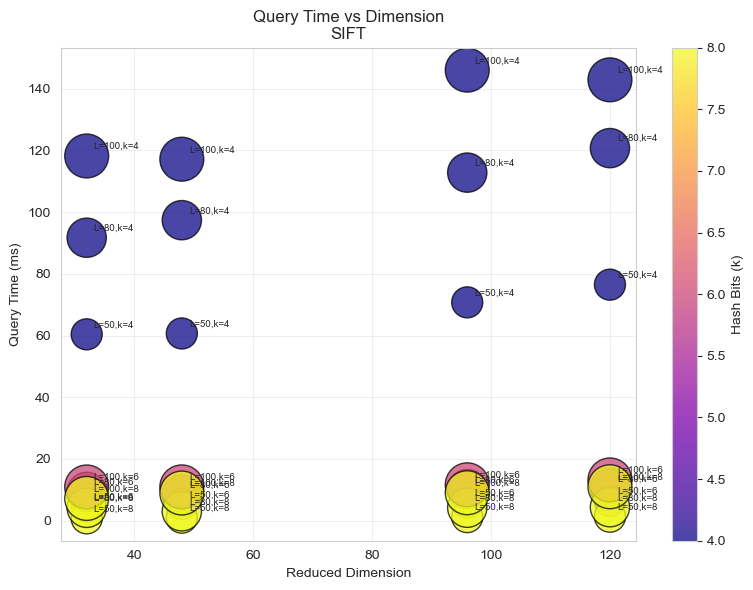

  -> Query-time vs dim plot saved to ../results/lsh_sift_querytime_vs_dim.png
  - Dimension = 32


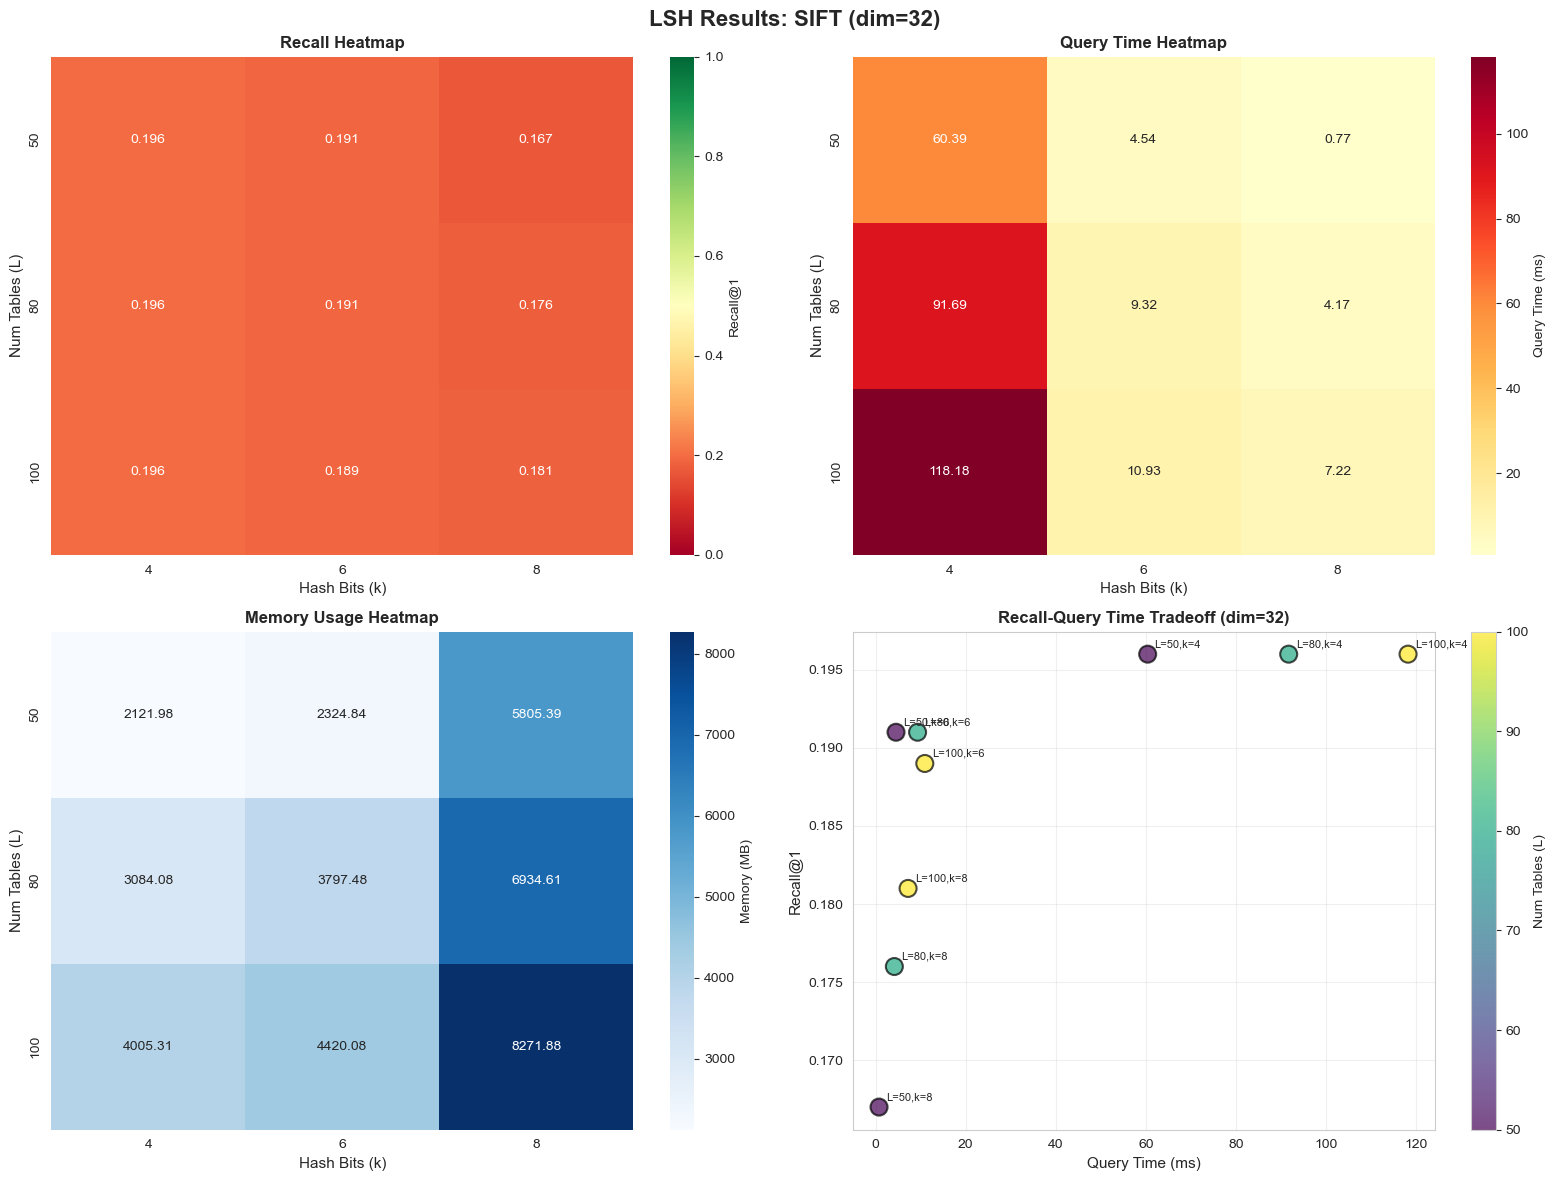

  -> Plot saved to ../results/lsh_sift_dim32_tradeoffs.png
  - Dimension = 48


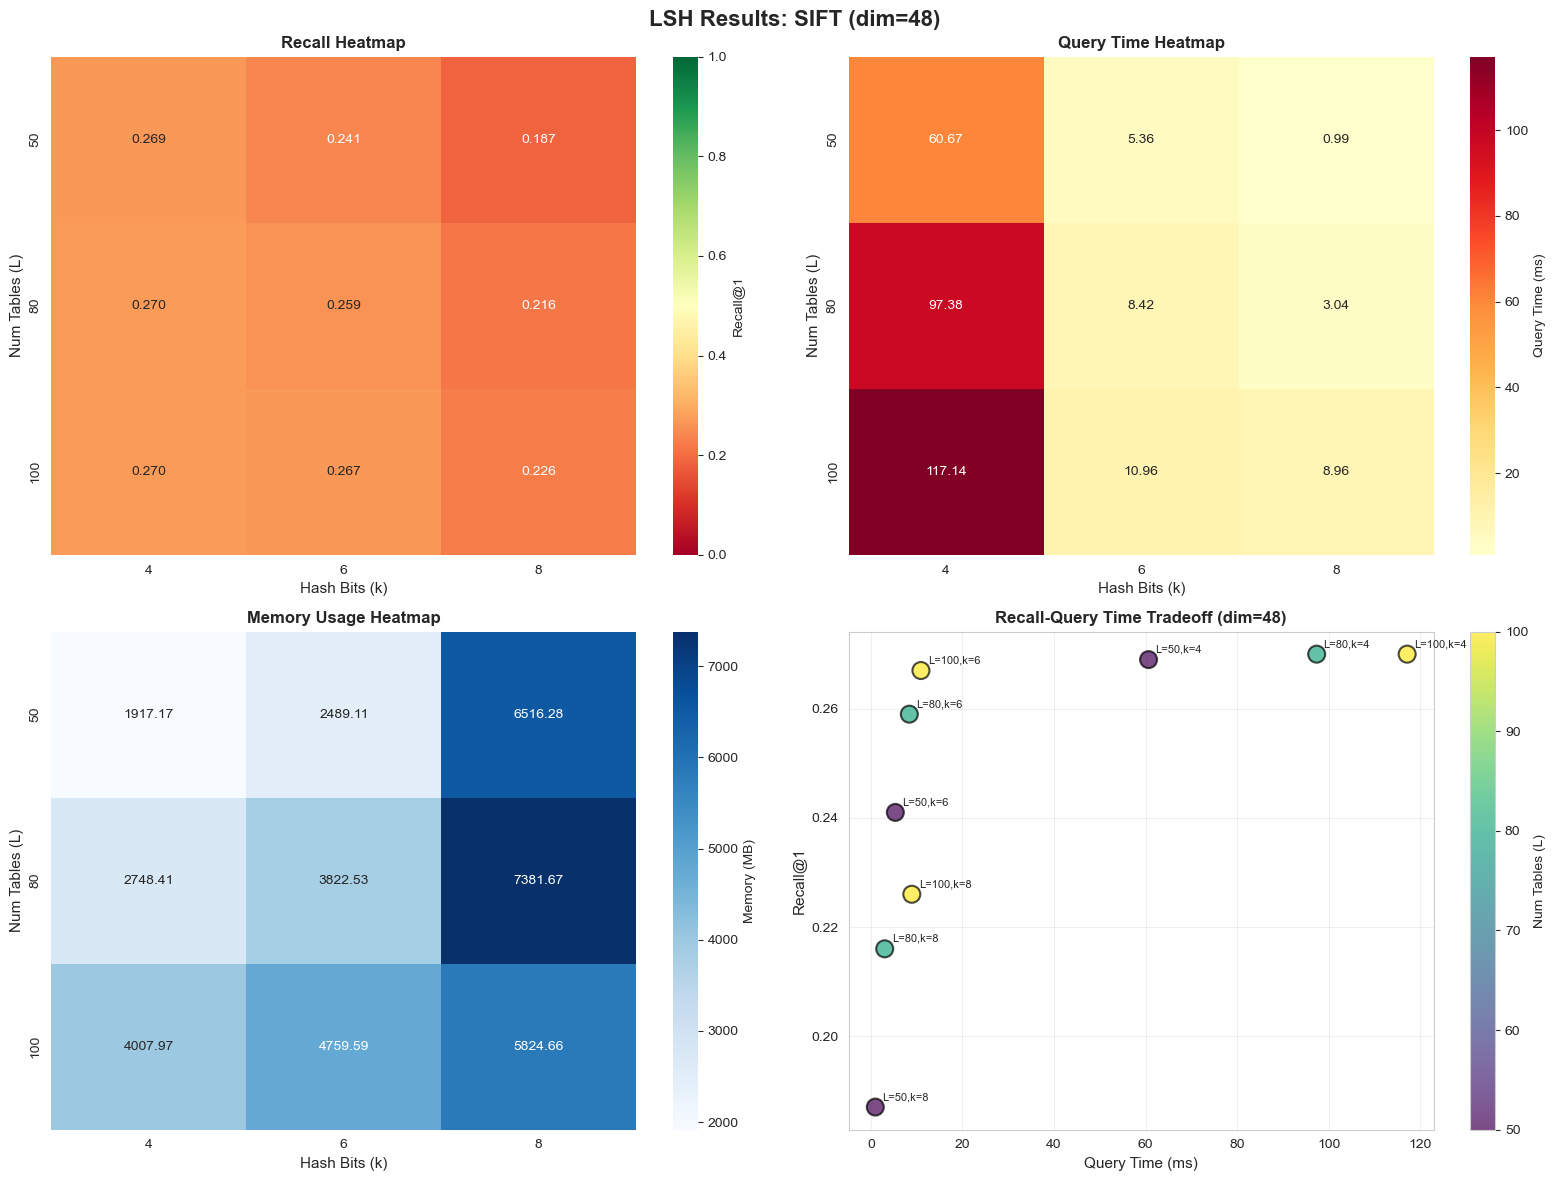

  -> Plot saved to ../results/lsh_sift_dim48_tradeoffs.png
  - Dimension = 96


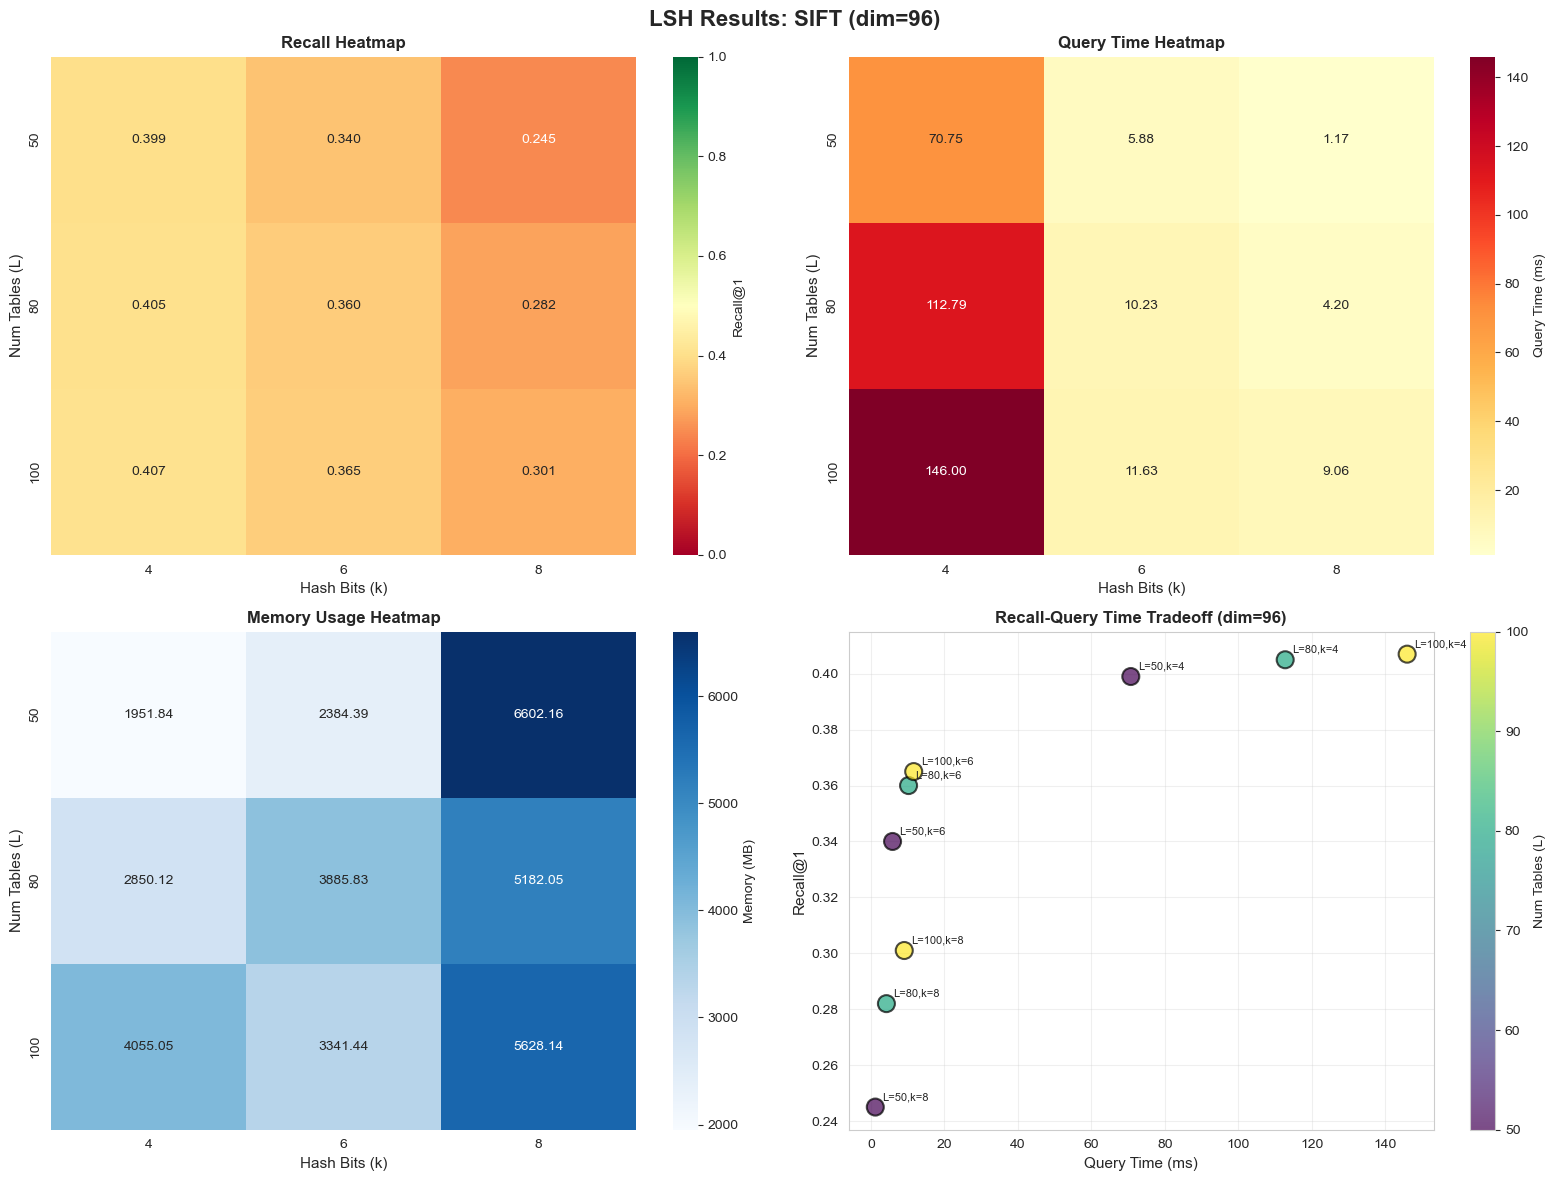

  -> Plot saved to ../results/lsh_sift_dim96_tradeoffs.png
  - Dimension = 120


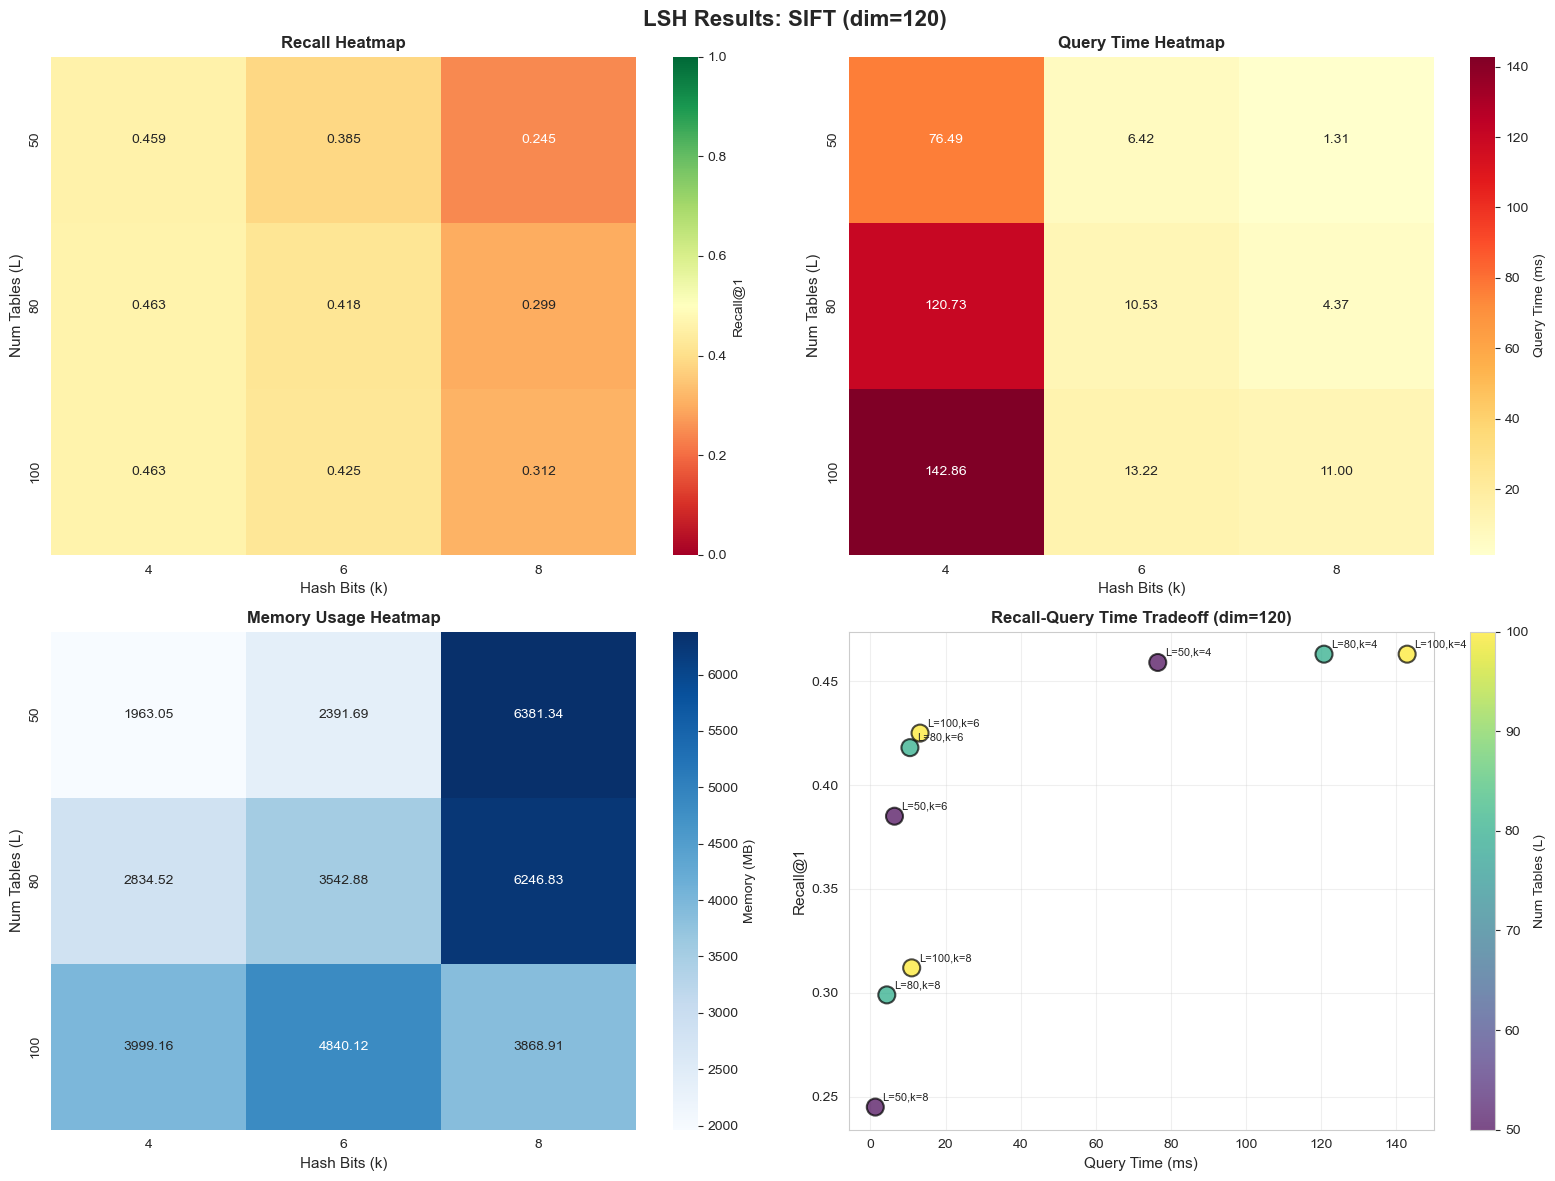

  -> Plot saved to ../results/lsh_sift_dim120_tradeoffs.png


In [6]:

for dataset_name, results_list in all_results.items():
    if not results_list:
        continue

    # --- Group results by dimension ---
    results_by_dim = defaultdict(list)
    for r in results_list:
        results_by_dim[r['d']].append(r)

    print(f"\nPlotting results for {dataset_name.upper()}...")

    # ============================
    # 1. LOOP OVER EACH DIMENSION
    # ============================
    for dim_val in sorted(results_by_dim.keys()):
        dim_results = results_by_dim[dim_val]

        # (your heatmaps + tradeoff plots here)
        # ...
        # ...
        # end of dim loop

    # =======================================
    # 2. PLOT RELATIONSHIP ACROSS DIMENSIONS
    #    (ONLY ONCE PER DATASET)
    # =======================================
    dims_all        = [r['d'] for r in results_list]
    L_all           = [r['lsh_num_tables'] for r in results_list]
    k_all           = [r['lsh_hash_bits'] for r in results_list]
    query_times_all = [r['avg_query_time_ms'] for r in results_list]

    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(
        dims_all, query_times_all,
        c=k_all, s=np.array(L_all) * 10,   # size = L, color = k
        cmap='plasma', alpha=0.75,
        edgecolors='black', linewidth=1
    )

    for d_val, L_val, k_val, qt in zip(dims_all, L_all, k_all, query_times_all):
        ax.annotate(
            f'L={L_val},k={k_val}',
            (d_val, qt),
            textcoords='offset points', xytext=(5, 5),
            fontsize=7
        )

    ax.set_xlabel('Reduced Dimension')
    ax.set_ylabel('Query Time (ms)')
    ax.set_title(f'Query Time vs Dimension\n{dataset_name.upper()}')

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Hash Bits (k)')

    ax.grid(alpha=0.3)

    plot_path = os.path.join(RESULTS_DIR, f'lsh_{dataset_name}_querytime_vs_dim.png')
    plt.tight_layout()
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"  -> Query-time vs dim plot saved to {plot_path}")


    # Sort dimensions for nicer ordering
    
    for dim_val in sorted(results_by_dim.keys()):
        dim_results = results_by_dim[dim_val]
        print(f"  - Dimension = {dim_val}")

        # Extract data for this dimension
        num_tables_list = [r['lsh_num_tables'] for r in dim_results]
        hash_bits_list = [r['lsh_hash_bits'] for r in dim_results]
        recalls = [r['recall@k'] for r in dim_results]
        query_times = [r['avg_query_time_ms'] for r in dim_results]
        memories = [r['memory_mb'] for r in dim_results]

        # Create pivot tables for heatmaps (L × k for this dim)
        recall_pivot = np.zeros((len(NUM_TABLES_OPTIONS), len(HASH_BITS_OPTIONS)))
        query_time_pivot = np.zeros_like(recall_pivot)
        memory_pivot = np.zeros_like(recall_pivot)

        for r in dim_results:
            i = NUM_TABLES_OPTIONS.index(r['lsh_num_tables'])
            j = HASH_BITS_OPTIONS.index(r['lsh_hash_bits'])
            recall_pivot[i, j] = r['recall@k']
            query_time_pivot[i, j] = r['avg_query_time_ms']
            memory_pivot[i, j] = r['memory_mb']

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(
            f'LSH Results: {dataset_name.upper()} (dim={dim_val})',
            fontsize=16, fontweight='bold'
        )

        # 1. Recall Heatmap
        sns.heatmap(
            recall_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=HASH_BITS_OPTIONS, yticklabels=NUM_TABLES_OPTIONS,
            vmin=0, vmax=1, ax=axes[0, 0],
            cbar_kws={'label': f'Recall@{K}'}
        )
        axes[0, 0].set_xlabel('Hash Bits (k)', fontsize=11)
        axes[0, 0].set_ylabel('Num Tables (L)', fontsize=11)
        axes[0, 0].set_title('Recall Heatmap', fontsize=12, fontweight='bold')

        # 2. Query Time Heatmap
        sns.heatmap(
            query_time_pivot, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=HASH_BITS_OPTIONS, yticklabels=NUM_TABLES_OPTIONS,
            ax=axes[0, 1], cbar_kws={'label': 'Query Time (ms)'}
        )
        axes[0, 1].set_xlabel('Hash Bits (k)', fontsize=11)
        axes[0, 1].set_ylabel('Num Tables (L)', fontsize=11)
        axes[0, 1].set_title('Query Time Heatmap', fontsize=12, fontweight='bold')

        # 3. Memory Usage Heatmap
        sns.heatmap(
            memory_pivot, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=HASH_BITS_OPTIONS, yticklabels=NUM_TABLES_OPTIONS,
            ax=axes[1, 0], cbar_kws={'label': 'Memory (MB)'}
        )
        axes[1, 0].set_xlabel('Hash Bits (k)', fontsize=11)
        axes[1, 0].set_ylabel('Num Tables (L)', fontsize=11)
        axes[1, 0].set_title('Memory Usage Heatmap', fontsize=12, fontweight='bold')

        # 4. Recall vs Query Time (for this dimension), color by L, annotate k
        scatter = axes[1, 1].scatter(
            query_times, recalls, s=150,
            c=num_tables_list, cmap='viridis',
            alpha=0.7, edgecolors='black', linewidth=1.5
        )

        for i, (nt, hb) in enumerate(zip(num_tables_list, hash_bits_list)):
            axes[1, 1].annotate(
                f'L={nt},k={hb}',
                (query_times[i], recalls[i]),
                textcoords="offset points", xytext=(5, 5),
                ha='left', fontsize=8
            )

        axes[1, 1].set_xlabel('Query Time (ms)', fontsize=11)
        axes[1, 1].set_ylabel(f'Recall@{K}', fontsize=11)
        axes[1, 1].set_title(
            f'Recall-Query Time Tradeoff (dim={dim_val})',
            fontsize=12, fontweight='bold'
        )
        axes[1, 1].grid(True, alpha=0.3)
        cbar = plt.colorbar(scatter, ax=axes[1, 1])
        cbar.set_label('Num Tables (L)', fontsize=10)

        plt.tight_layout()
        plot_path = os.path.join(
            RESULTS_DIR, f'lsh_{dataset_name}_dim{dim_val}_tradeoffs.png'
        )
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.show()

        print(f"  -> Plot saved to {plot_path}")


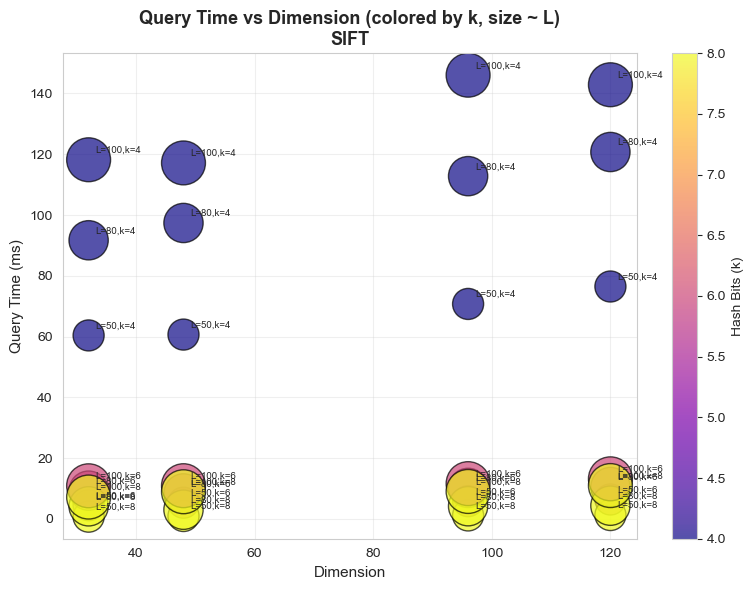

  -> Query-time vs dim plot saved to ../results/lsh_sift_querytime_vs_dim.png


In [7]:
    # After the per-dimension loop, for this dataset:
    # single scatter showing (dim, L, k) -> query_time
    dims_all        = [r['d'] for r in results_list]
    L_all           = [r['lsh_num_tables'] for r in results_list]
    k_all           = [r['lsh_hash_bits'] for r in results_list]
    query_times_all = [r['avg_query_time_ms'] for r in results_list]

    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(
        dims_all, query_times_all,
        c=k_all, s=np.array(L_all) * 10,  # size ~ L, color ~ k
        cmap='plasma', alpha=0.7, edgecolors='black', linewidth=1.0
    )

    for d_val, L_val, k_val, qt in zip(dims_all, L_all, k_all, query_times_all):
        ax.annotate(
            f'L={L_val},k={k_val}',
            (d_val, qt),
            textcoords='offset points', xytext=(5, 5),
            fontsize=7
        )

    ax.set_xlabel('Dimension', fontsize=11)
    ax.set_ylabel('Query Time (ms)', fontsize=11)
    ax.set_title(f'Query Time vs Dimension (colored by k, size ~ L)\n{dataset_name.upper()}',
                 fontsize=13, fontweight='bold')
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Hash Bits (k)')
    ax.grid(True, alpha=0.3)

    plot_path = os.path.join(RESULTS_DIR, f'lsh_{dataset_name}_querytime_vs_dim.png')
    plt.tight_layout()
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  -> Query-time vs dim plot saved to {plot_path}")


## 5. Find Best Configurations

For each dataset, identify the best LSH configuration based on different criteria.

In [8]:
if all_results:
    print("\n" + "="*80)
    print("BEST CONFIGURATIONS PER DATASET")
    print("="*80 + "\n")
    
    for dataset_name, results_list in all_results.items():
        if not results_list:
            continue
        
        print(f"\n{dataset_name.upper()}:")
        print("-" * 60)
        
        # Best recall
        best_recall = max(results_list, key=lambda x: x['recall@k'])
        print(f"\n  Best Recall:")
        print(f"    L={best_recall['lsh_num_tables']}, k={best_recall['lsh_hash_bits']}")
        print(f"    Recall@{K}: {best_recall['recall@k']:.4f}")
        print(f"    Query time: {best_recall['avg_query_time_ms']:.3f} ms")
        print(f"    Memory: {best_recall['memory_mb']:.3f} MB")
        
        # Fastest query time (with recall >= 0.8)
        high_recall_configs = [r for r in results_list if r['recall@k'] >= 0.8]
        if high_recall_configs:
            fastest = min(high_recall_configs, key=lambda x: x['avg_query_time_ms'])
            print(f"\n  Fastest Query Time (Recall ≥ 0.8):")
            print(f"    L={fastest['lsh_num_tables']}, k={fastest['lsh_hash_bits']}")
            print(f"    Recall@{K}: {fastest['recall@k']:.4f}")
            print(f"    Query time: {fastest['avg_query_time_ms']:.3f} ms")
            print(f"    Memory: {fastest['memory_mb']:.3f} MB")
        
        # Most memory efficient (with recall >= 0.8)
        if high_recall_configs:
            mem_efficient = min(high_recall_configs, key=lambda x: x['memory_mb'])
            print(f"\n  Most Memory Efficient (Recall ≥ 0.8):")
            print(f"    L={mem_efficient['lsh_num_tables']}, k={mem_efficient['lsh_hash_bits']}")
            print(f"    Recall@{K}: {mem_efficient['recall@k']:.4f}")
            print(f"    Query time: {mem_efficient['avg_query_time_ms']:.3f} ms")
            print(f"    Memory: {mem_efficient['memory_mb']:.3f} MB")
        
        print()


BEST CONFIGURATIONS PER DATASET


SIFT:
------------------------------------------------------------

  Best Recall:
    L=80, k=4
    Recall@1: 0.4630
    Query time: 120.733 ms
    Memory: 2834.516 MB



## 6. Summary Statistics Table

In [11]:
# Flatten all results for summary
all_results_flat = []
for dataset_name, results_list in all_results.items():
    all_results_flat.extend(results_list)

if all_results_flat:
    print("\n" + "="*100)
    print("SUMMARY: ALL LSH CONFIGURATIONS")
    print("="*100)
    
    # Header
    print(f"{'Dataset':<10} {'L':<6} {'k':<6} {'dim' : <6} {'Recall@10':<12} {'Query(ms)':<12} {'Memory(MB)':<12} {'Build(s)':<10}")
    print("-" * 100)
    
    # Sort by dataset, then num_tables, then hash_bits
    sorted_results = sorted(all_results_flat, 
                          key=lambda x: (x['dataset'], x['lsh_num_tables'], x['lsh_hash_bits']))
    
    for r in sorted_results:
        print(f"{r['dataset'].upper():<10} "
              f"{r['lsh_num_tables']:<6} "
              f"{r['lsh_hash_bits']:<6} "
              f"{r['d']:<6} "
              f"{r['recall@k']:<12.4f} "
              f"{r['avg_query_time_ms']:<12.3f} "
              f"{r['memory_mb']:<12.3f} "
              f"{r['build_time_s']:<10.3f}")
    
    # Save comprehensive summary
    summary = {
        'experiment': 'LSH',
        'k': K,
        'n_test': N_TEST,
        'num_tables_options': NUM_TABLES_OPTIONS,
        'hash_bits_options': HASH_BITS_OPTIONS,
        'configurations_tested': len(all_results_flat),
        'results_by_dataset': all_results
    }
    
    summary_path = os.path.join(RESULTS_DIR, 'lsh_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\nComprehensive summary saved to {summary_path}")


SUMMARY: ALL LSH CONFIGURATIONS
Dataset    L      k      dim    Recall@10    Query(ms)    Memory(MB)   Build(s)  
----------------------------------------------------------------------------------------------------
SIFT       50     4      32     0.1960       60.391       2121.984     57.938    
SIFT       50     4      48     0.2690       60.671       1917.172     53.188    
SIFT       50     4      96     0.3990       70.749       1951.844     60.431    
SIFT       50     4      120    0.4590       76.487       1963.047     46.182    
SIFT       50     6      32     0.1910       4.541        2324.844     57.297    
SIFT       50     6      48     0.2410       5.361        2489.109     75.106    
SIFT       50     6      96     0.3400       5.875        2384.391     62.051    
SIFT       50     6      120    0.3850       6.418        2391.688     63.586    
SIFT       50     8      32     0.1670       0.771        5805.391     92.948    
SIFT       50     8      48     0.1870       0

## 7. Key Observations

**Expected Results:**
- **More hash tables (L)**: Higher recall but slower query time and more memory
- **More hash bits (k)**: Finer bucketing → fewer candidates per bucket → lower recall but faster
- **Optimal balance**: Need enough L for high recall, but not so much that query time suffers

**LSH Theory:**
- LSH guarantees sublinear query time: O(n^ρ) where ρ < 1 depends on approximation factor
- Space complexity: O(nL) where L is number of tables
- More tables → better recall but more redundancy

**Tradeoffs:**
- **High L, Low k**: Best recall, slower queries, more memory
- **Low L, High k**: Fast queries, less memory, but lower recall
- **Sweet spot**: Find (L, k) where recall ≥ 0.9 with reasonable query time

**Next Steps:**
Compare these results against:
1. Baseline brute-force KNN (notebook 01)
2. JL+KNN (notebook 02)
3. JL+LSH combination (future work)